1. [Imports](#ims)
2. [Data preprocessing](#pp)  

# 1. Imports<a name="ims"></a>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from collections import Counter
import statsmodels
# from data_prepare import df_train, df_prediction, non_na_y_train_materialHardship

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

Let's read df_train, df_prediction, non_na_y_train_materialHardship from pickled files. 

In [2]:
df_train, df_prediction, non_na_y_train_materialHardship = pd.read_pickle('df_train'), pd.read_pickle('df_prediction'), pd.read_pickle('non_na_y_train_materialHardship')

In [3]:
mean_impute_df_train, median_impute_df_train, final_over_balanced = pd.read_pickle('mean_impute_df_train'), pd.read_pickle('median_impute_df_train'), pd.read_pickle('final_over_balanced')

Check out what kinds of data we have:

# 2. Data Preprocessing<a name="pp"></a>

## 2a. Combine features and labels 

We need to stick training features and class labels for materialHardship together before the next step.

In [4]:
all_training = pd.merge(df_train, non_na_y_train_materialHardship, on='challengeID')
all_training.head()

,challengeID,m1intmon,m1intyr,m1lenhr,m1lenmin,cm1twoc,cm1fint,cm1tdiff,cm1natsm,m1natwt,...,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1,materialHardship
0,6,-3,NaN,0,25,NaN,1,NaN,NaN,NaN,...,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3,-3.000000,10.255825,0.090909
1,7,-3,NaN,0,35,NaN,1,NaN,NaN,NaN,...,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3,10.972726,10.859800,0.000000
2,9,-3,NaN,0,30,NaN,1,NaN,NaN,NaN,...,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3,9.842380,9.566678,0.181818
3,10,-3,NaN,0,33,NaN,1,NaN,NaN,NaN,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3,-3.000000,10.105870,0.090909
4,13,-3,NaN,1,-3,NaN,1,NaN,NaN,NaN,...,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3,-3.000000,9.566678,0.181818


## 2b. Data augumentation

In image processing, if people have n pictures to train on, they will artificially increase the size of their training set by randomly altering a few pixels. They call this data [augmentation](https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=data+augmentation+image+classification). This of course keeps the class of the image (eg cat) the same, but it gives the model a little bit extra of variation to learn from. This seems like it would work here, too. For example:

If Joe has a homeless mom who is single, and relatives visit 3x per week and Joe experiences 5/11 on material hardship, it seems reasonable to create another hypothetical individual who also has a homeless and single mom, whose relatives visit 2x a week and also experiences 5/11. If we feed both individuals to the model, it will hopefully learn better that the single and homeless mom is a strong predictor of material hardship, regardless of relative visitation.

In [5]:
# this code takes a long time to run! pickle copy once made

# copy = all_training # copy all_training
# copy = copy.astype(object) # convert to object type for all so we dont have any dtype problems
# # copy.dtypes 
# for i in range(all_training.shape[0]):
#     choose_col = all_training.sample(1,axis=1) # choose 1 column at random
#     unique_values = choose_col.ix[:,0].unique() # what are its unique values
#     pick_rand_value = np.random.choice(unique_values, 1) # pick random value
#     copy.set_value(i, choose_col.columns, pick_rand_value) # set this value in row i and column choose_col
# copy.head()
# copy.to_pickle('copy')

## 2c. Data balancing - undersampling

We have very imbalanced predictor classes (e.g. most people don't have a lot of material hardship, even though we have a 0-11 scale possible). There are many different tactics to combat this problem...let's try to do some *informed* undersampling, where we elimate training data from the majority class (low material hardship) such that the distribution of key predictors remains unchanged.

Also, we will want to look at using different metrics for success like ROC AUC when doing prediction, but we'll get to that later. For now, let's try to export a balanced training set. 

In [6]:
XX= np.asarray(median_impute_df_train)
yy = np.asarray(non_na_y_train_materialHardship['materialHardship'])

In [7]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(XX, yy)

/anaconda/envs/py35/lib/python3.5/site-packages/imblearn/base.py:343: UserWarning: The target type should be binary or multiclass.
  warnings.warn('The target type should be binary or multiclass.')


In [8]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(yy)))
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

Original dataset shape Counter({0.0: 807, 0.090909090909090898: 248, 0.18181818181818202: 136, 0.27272727272727298: 104, 0.36363636363636404: 61, 0.45454545454545503: 58, 0.54545454545454497: 26, 0.63636363636363591: 11, 0.72727272727272707: 6, 0.81818181818181801: 2})
Resampled dataset shape Counter({0.81818181818181801: 2, 0.090909090909090898: 2, 0.18181818181818202: 2, 0.45454545454545503: 2, 0.27272727272727298: 2, 0.54545454545454497: 2, 0.36363636363636404: 2, 0.72727272727272707: 2, 0.63636363636363591: 2, 0.0: 2})


Undersampling worked, kinda. We were able to get even distribution, but we only have {{y_resampled.shape[0]}} rows in the new data. This is because, in the training data, we only have 2 families with 9/11 material hardship, so we rebalanced to now have 2 families for each MH score out of 11. So the balance is good, but we can't do much with 20 training observations.

Let's try to oversample.

## 2c. Data balancing - oversampling

In [9]:
from imblearn.over_sampling import SMOTE

**To do:** Maybe change the k_neighbors param for SMOTE

In [10]:
sm = SMOTE(random_state=42,k_neighbors=1) 
# X_res, y_res = sm.fit_sample(XX, yy)

In [11]:
# print('Resampled dataset shape {}'.format(Counter(y_res)))

In [12]:
# yy.shape

This kind of worked too, but not super well. Right now, we are heavility sampling those with a 9/11 material hardship score. We don't need to focus so much on these people, since they are so rare.

Over and undersampling isn't going great right now. Having 11 classes is sort of messing with me. Perhaps a better strategy would be to take my training data (with labels) and siphon off just the rows for which material hardship score was in {0,1,2,3,4} or something. I could SMOTE oversample on this to get balance amongst these more common outcomes. If we are predicting MH right for these, our model is doing well enough. 

Let's see if I can do it really quickly.

In [13]:
median_all = pd.merge(median_impute_df_train, non_na_y_train_materialHardship, on='challengeID')
median_all.shape

(1459, 11985)

In [14]:
7/11

0.6363636363636364

In [15]:
median_all_low_mh = median_all[median_all['materialHardship']<(7/11)] # just look for obs where mh < 7
# this is because we have very few obs for mh>7...so trying to sample from those (using knn) is hard

In [16]:
median_all_low_mh.shape

(1451, 11985)

Split median_all_low_mh back into X and Ys...

In [17]:
y = median_all_low_mh.iloc[:,-1]
y_arr = np.asarray(y)

x = median_all_low_mh.drop('materialHardship', axis=1)
x_arr =np.asarray(x)

In [18]:
X_resamp, y_resamp = sm.fit_sample(x, y)
X_resamp, y_resamp = sm.fit_sample(X_resamp, y_resamp) # call multiple times to iterature though all classes
X_resamp, y_resamp = sm.fit_sample(X_resamp, y_resamp)
X_resamp, y_resamp = sm.fit_sample(X_resamp, y_resamp)
X_resamp, y_resamp = sm.fit_sample(X_resamp, y_resamp)
X_resamp, y_resamp = sm.fit_sample(X_resamp, y_resamp)
X_resamp, y_resamp = sm.fit_sample(X_resamp, y_resamp)

/anaconda/envs/py35/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/anaconda/envs/py35/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/anaconda/envs/py35/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/anaconda/envs/py35/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/anaconda/envs/py35/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/anaconda/envs/py35/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type 

In [19]:
print('Resampled dataset shape {}'.format(Counter(y_resamp)))

Resampled dataset shape Counter({0.090909090909090898: 807, 0.0: 807, 0.18181818181818202: 807, 0.45454545454545503: 807, 0.27272727272727298: 807, 0.54545454545454497: 807, 0.36363636363636404: 807, 0.63636363636363591: 807})


OK. This worked better. Now, to finish up, we want to tag back on obs we left out.

In [20]:
x_resamped = pd.DataFrame(X_resamp)
x_resamped.columns = median_impute_df_train.columns.values
x_resamped.reset_index(inplace=True)
x_resamped.head()

,index,challengeID,m1intmon,m1lenhr,m1lenmin,cm1fint,cm1citsm,m1citywt,innatsm,incitysm,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
0,0,6.0,-3.0,0.0,25.0,1.0,1.0,10.593024,1.0,1.0,...,8.51570,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3.0,-3.000000,10.255825
1,1,7.0,-3.0,0.0,35.0,1.0,1.0,531.335144,1.0,1.0,...,-3.00000,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3.0,10.972726,10.859800
2,2,9.0,-3.0,0.0,30.0,1.0,1.0,90.466721,0.0,1.0,...,-3.00000,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3.0,9.842380,9.566678
3,3,10.0,-3.0,0.0,33.0,1.0,1.0,6.155746,1.0,1.0,...,-3.00000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3.0,-3.000000,10.105870
4,4,13.0,-3.0,1.0,-3.0,1.0,1.0,5.496325,0.0,1.0,...,10.78074,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3.0,-3.000000,9.566678


In [21]:
y_resamped = pd.DataFrame(y_resamp)
y_resamped.columns = ['materialHardship']
y_resamped.reset_index(inplace=True)

In [22]:
resamped_x_y = pd.merge(x_resamped, y_resamped, on='index')
resamped_x_y.head()

,index,challengeID,m1intmon,m1lenhr,m1lenmin,cm1fint,cm1citsm,m1citywt,innatsm,incitysm,...,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1,materialHardship
0,0,6.0,-3.0,0.0,25.0,1.0,1.0,10.593024,1.0,1.0,...,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3.0,-3.000000,10.255825,0.090909
1,1,7.0,-3.0,0.0,35.0,1.0,1.0,531.335144,1.0,1.0,...,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3.0,10.972726,10.859800,0.000000
2,2,9.0,-3.0,0.0,30.0,1.0,1.0,90.466721,0.0,1.0,...,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3.0,9.842380,9.566678,0.181818
3,3,10.0,-3.0,0.0,33.0,1.0,1.0,6.155746,1.0,1.0,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3.0,-3.000000,10.105870,0.090909
4,4,13.0,-3.0,1.0,-3.0,1.0,1.0,5.496325,0.0,1.0,...,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3.0,-3.000000,9.566678,0.181818


Now, let's add back the high material hardship obs we left out. 

In [23]:
high_mh = median_all[median_all['materialHardship']>=(7/11)] # just look for obs where mh < 7
high_mh.shape

(8, 11985)

And the shape of the resampled df is {{resamped_x_y.shape[0]}} x {{resamped_x_y.shape[1]}}. Our new df should have {{resamped_x_y.shape[0] + high_mh.shape[0]}} rows!

In [24]:
final_over_balanced = resamped_x_y.append(high_mh)
final_over_balanced.shape

(6464, 11986)

In [25]:
final_over_balanced['challengeID']

0          6.000000
1          7.000000
2          9.000000
3         10.000000
4         13.000000
5         14.000000
6         16.000000
7         18.000000
8         20.000000
9         23.000000
10        24.000000
11        30.000000
12        35.000000
13        40.000000
14        43.000000
15        45.000000
16        46.000000
17        47.000000
18        52.000000
19        53.000000
20        55.000000
21        57.000000
22        58.000000
23        60.000000
24        61.000000
25        62.000000
26        64.000000
27        66.000000
28        67.000000
29        69.000000
           ...     
6434    3166.598646
6435    2881.425257
6436    2272.061991
6437    1335.521285
6438    1235.938427
6439    1913.864483
6440     986.674124
6441    3513.637087
6442    1918.673952
6443    1943.141939
6444     862.574217
6445     649.588874
6446    1642.592910
6447     909.851704
6448    2877.181317
6449    1311.676119
6450    1454.865759
6451    1511.893188
6452     835.462304


Sweet. We are in business. A quick visualization should show that there is more balance in this new df. 

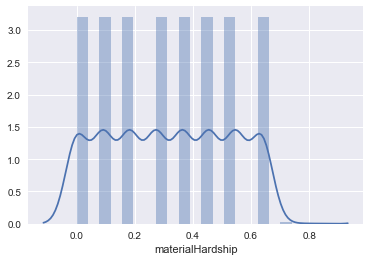

In [26]:
sns.distplot(final_over_balanced['materialHardship'])
plt.show()

In [52]:
# sort cols alphabetically
final_over_balanced.reindex_axis(sorted(final_over_balanced.columns), axis=1)
final_over_balanced.head()

,c2citywt,c2citywt_rep1,c2citywt_rep10,c2citywt_rep2,c2citywt_rep3,c2citywt_rep4,c2citywt_rep5,c2citywt_rep6,c2citywt_rep7,c2citywt_rep8,...,t5g4i,t5g4j,t5g4k,t5g5,t5g6,t5g7,t5g8,t5g9_age,t5status,t5tint
0,11.134632,13.075468,13.862883,13.057703,11.229993,12.411758,12.993218,13.358963,0.000000,11.579317,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0
1,41.145229,38.750587,35.888996,38.882961,38.353191,37.669495,39.116447,38.526501,39.675743,39.874935,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0
2,104.055870,107.864006,0.000000,104.398315,109.786621,121.313026,123.207191,124.847580,114.975273,110.409531,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,65.0,1.0
3,41.145229,38.750587,35.888996,38.882961,38.353191,37.669495,39.116447,38.526501,39.675743,39.874935,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0
4,8.702942,11.572806,8.381824,9.364669,9.504119,0.000000,11.012741,10.537480,9.394835,12.157079,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0


In [53]:
final_over_balanced = final_over_balanced.drop('index', 1)
final_over_balanced.head()

,c2citywt,c2citywt_rep1,c2citywt_rep10,c2citywt_rep2,c2citywt_rep3,c2citywt_rep4,c2citywt_rep5,c2citywt_rep6,c2citywt_rep7,c2citywt_rep8,...,t5g4i,t5g4j,t5g4k,t5g5,t5g6,t5g7,t5g8,t5g9_age,t5status,t5tint
0,11.134632,13.075468,13.862883,13.057703,11.229993,12.411758,12.993218,13.358963,0.000000,11.579317,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0
1,41.145229,38.750587,35.888996,38.882961,38.353191,37.669495,39.116447,38.526501,39.675743,39.874935,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0
2,104.055870,107.864006,0.000000,104.398315,109.786621,121.313026,123.207191,124.847580,114.975273,110.409531,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,65.0,1.0
3,41.145229,38.750587,35.888996,38.882961,38.353191,37.669495,39.116447,38.526501,39.675743,39.874935,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0
4,8.702942,11.572806,8.381824,9.364669,9.504119,0.000000,11.012741,10.537480,9.394835,12.157079,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-9.0,0.0


# 3. Training data export<a name="ims"></a>

Let's now export various training dataframes so we can train on validation data in our next notebook. Here are the various flavors available:

- Plain jane training set (with crap ton of NAs): df_train

Imputed: 

- Mean imputation method: mean_impute_df_train
- Median imputation method: median_impute_df_train
- ~~MICE imputation method: mice_impute_df_train~~

All of the above should be merged onto the y values given by non_na_y_train_materialHardship. 

Augmented:

- ~~Augmented data: augmented_df_train~~

Class balanced:

- Balanced label data: balanced_label_df_train (goes with final_over_balanced['materialHardship']. Can just use final_over_balanced for full features + classes df)


In [55]:
final_over_balanced.to_pickle('final_over_balanced_decimals')